# Coordinates to Pixels: Polygon as Mask

This notebook contains parts of code from Dr. Vadim Savenkov

In [2]:
import os, io, json
import pandas as pd
import geopandas as gpd
from ast import literal_eval
from shapely.geometry import shape, mapping as shapely_mapping
from shapely import wkt
import folium
from PIL import Image, ImageDraw
from __future__ import print_function
from ipywidgets import interact,interact_manual,HBox,Output,Tab
import time

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import shutil
import cv2
import statistics
from decimal import *
import random
import re
import sys
import multiprocessing.dummy as mp 
import numpy as np
import xml.etree.ElementTree as ET
from xml.dom import minidom

### Get unique IDs

In [2]:
# Get the first point of a polygon geometry string
def get_point_poly(geom):
    try:
        pt = re.split(r",", geom[9:])[0]
        pt = tuple(map(float, pt.split(' ')))
        pt_s = (pt[1], pt[0])
    except:
        print(sys.exc_info())
        return np.nan
    
    return pt_s

# Get all points of a polygon geometry string
def get_point_ls(geom):
    try:
        pt_ls = re.split(r",", geom[9:])
        for i in range(len(pt_ls)):
            temp = pt_ls[i].strip()
            temp = re.sub("[^\d. -]+", "", temp)
            temp = tuple(map(float, temp.split(' ')))
            pt_ls[i] = (temp[1], temp[0])
    except:
        print(sys.exc_info())
        return np.nan
    
    return pt_ls

### Load data

In [3]:
# TRUCKS
# Load filtered list
df = pd.read_csv("data/osm_data_trucks.csv", index_col=0)
PARKING_TYPE = "TRUCK"

In [4]:
# CARS
# Load filtered list
#df = pd.read_csv("ndata/osm_data_cars.csv", index_col=0)
#PARKING_TYPE = "CAR"

In [5]:
# Define pt tuple again and set geometry
df["pt"] = df["geometry"].transform(lambda x: get_point_poly(x))
df["pt_ls"] = df["geometry"].transform(lambda x: get_point_ls(x))
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create Geo DataFrame
real_polys = gpd.GeoDataFrame(df, geometry="geometry")

# Set index column and sort index
real_polys.set_index("id", inplace=True)
real_polys.sort_index(inplace=True)

In [6]:
real_polys

,pt,geometry,all_tags,pt_ls
id,,,,
-17.9495555_25.8216612_ts2,"(-17.9495555, 25.8216612)","POLYGON ((25.82166 -17.94956, 25.82349 -17.950...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(-17.9495555, 25.8216612), (-17.9502199, 25.8..."
-20.6925135_139.4888175_ts1,"(-20.6925135, 139.4888175)","POLYGON ((139.48882 -20.69251, 139.48911 -20.6...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(-20.6925135, 139.4888175), (-20.6926171, 139..."
-20.6925135_139.4888175_ts2,"(-20.6925135, 139.4888175)","POLYGON ((139.48882 -20.69251, 139.48911 -20.6...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(-20.6925135, 139.4888175), (-20.6926171, 139..."
-23.5336629_148.1722669_ts2,"(-23.5336629, 148.1722669)","POLYGON ((148.17227 -23.53366, 148.17327 -23.5...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(-23.5336629, 148.1722669), (-23.5337976, 148..."
-24.4068105_150.4983079_ts1,"(-24.4068105, 150.4983079)","POLYGON ((150.49831 -24.40681, 150.49860 -24.4...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(-24.4068105, 150.4983079), (-24.4067243, 150..."
...,...,...,...,...
58.5918689_29.822495_ts2,"(58.5918689, 29.822495)","POLYGON ((29.82249 58.59187, 29.82274 58.59267...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(58.5918689, 29.822495), (58.5926656, 29.8227..."
59.1297703_11.2738828_ts1,"(59.1297703, 11.2738828)","POLYGON ((11.27388 59.12977, 11.27410 59.12965...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(59.1297703, 11.2738828), (59.1296506, 11.274..."
59.1297703_11.2738828_ts2,"(59.1297703, 11.2738828)","POLYGON ((11.27388 59.12977, 11.27410 59.12965...","[{'key': 'amenity', 'value': 'parking'}, {'key...","[(59.1297703, 11.2738828), (59.1296506, 11.274..."


### Create Maps

In [7]:
# Create an unique id based on position of parking lot
def parking_name(row):
    pt = row.pt
    ts = int(row.name[-1])
    
    return f"{round(pt[0],7)}_{round(pt[1],7)}_ts{ts}"

In [8]:
# Given West, North, East, South, return [southeast, northwest] for folium
def wnes2rect(w,n,e,s):
    return [[s,e],[n,w]]

# Turn r, g, b integers into a CSS color code 
def rgbcolor(r,g,b):
    return f"#{r:02x}{g:02x}{b:02x}"

# Get the bounding box around an arbitrarily shaped geometry object
def geometry_bbox(geometry, init_bounds=None, x_offset=0., y_offset=0.):
    bounds = init_bounds or [[1000,-1000],[-1000,1000]]
    xs = [c[0] for c in geometry.exterior.coords]
    
    ys = [c[1] for c in geometry.exterior.coords]
    
    return [
        #southwest
        [min(bounds[0][0], min(ys)-y_offset), max(bounds[0][1], max(xs)+x_offset)],
        #northeast
        [max(bounds[1][0], max(ys)+y_offset), min(bounds[1][1], min(xs)-x_offset)]
    ]

In [9]:
def make_map(pt, ts, geometry=None, show_geometry=False, show_corners=False, pt_ls=None, show_bounds=False, size=640, seednr=100):
    """
    create folium map with a given center, 
    optionally fit and show a geometry and/or a larger bounding box
    """
    
    BOUNDS_RGB = (0xff,0x78, 0x00)
    
    # Create satellite image map for the coordinate point specified
    m = folium.Map(location=pt, min_zoom=15, width=size, height=size, zoom_control=False, attribution_control=False)
    
    if ts == 1:
        folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',  # Original tile server
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)
        
    elif ts == 2:
        folium.TileLayer(
            tiles = 'https://clarity.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', # New tile server
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)

    
    # Default bounds
    bounds = [[pt[0], pt[1]],[pt[0], pt[1]]] #southwest, northeast

    # Lines of geometry and Box around them ("Bounds")
    if geometry:
        if show_geometry:
            folium.GeoJson(data=geometry).add_to(m)

        bounds = geometry_bbox(geometry, init_bounds=bounds, x_offset=0, y_offset=0)
    
    # Plot box around geometry
    if show_bounds:
        folium.Rectangle(bounds=bounds, color=rgbcolor(*BOUNDS_RGB), fill=True, fill_color=rgbcolor(*BOUNDS_RGB), fill_opacity=0).add_to(m) 
    
    # Plot Icon on corner points
    if show_corners and pt_ls is not None:
        # Take first point
        folium.Circle(location=pt_ls[0], radius=0.01, color="#FF00FF").add_to(m) # Pink
        # Take point in middle of list
        m_point = round(len(pt_ls)/2)
        folium.Circle(location=pt_ls[m_point], radius=0.01, color="#FFFF00").add_to(m) # Yellow
    
    # Create random offset
    kalibr = 8000
    random.seed(seednr)
    r_nr_x = random.randint(1,9)
    x_offset_l = r_nr_x/kalibr
    x_offset_r = (9-r_nr_x)/kalibr
    
    random.seed(seednr+20)
    r_nr_y = random.randint(1,9)
    y_offset_l = r_nr_y/kalibr
    y_offset_r = (9-r_nr_y)/kalibr
    
    crop_bounds = [[bounds[0][0]-y_offset_l, bounds[0][1]+x_offset_l],[bounds[1][0]+y_offset_r, bounds[1][1]-x_offset_r]] #southwest, northeast
    
    # Create red random crop box
    if show_bounds:
        folium.Rectangle(bounds=crop_bounds, color="red", fill=False, fill_color=rgbcolor(*BOUNDS_RGB), fill_opacity=0.).add_to(m) 
    
    #m.fit_bounds(bounds, max_zoom = 18)
    m.fit_bounds(crop_bounds)
    
    return m, bounds

In [10]:
rnr = random.randint(0, len(real_polys)-1)
row = real_polys.iloc[rnr]
print(row.name)

seed = random.randint(1,9999)

m, b = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_geometry=True, show_bounds=True, show_corners=False, pt_ls=row.pt_ls, size=640, seednr=seed)
m

52.2316824_-1.0050941_ts1


In [ ]:
# Print same image but with other tile server if needed
"""
if row.name[-1] == "2":
    idc = row.name[:-1]+"1"
else:
    idc = row.name[:-1]+"2"
try:
    row = real_polys.loc[idc,:]
    m, b = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_geometry=True, show_bounds=False, show_corners=False, pt_ls=row.pt_ls, size=640, seednr=seed) # create map with boundaries
    display(m)
except:
    print("No image with other tile server available")
"""

### Generate training data

In [11]:
# Get rounded mean of a list
def get_m(ls):
    return round(statistics.mean(ls))

In [12]:
# Get Pixels per "Coordinate" (per longitude or latitude)
def get_ppc(p_0, p_1, coord_0, coord_1):
    getcontext().prec = 28
    
    dx_c = Decimal(str(coord_1[1])) - Decimal(str(coord_0[1])) # A! Coord: (Y,X)
    dy_c = Decimal(str(coord_1[0])) - Decimal(str(coord_0[0])) # A! Coord: (Y,X)

    dx_p = p_1[0] - p_0[0] # Px: (X,Y)
    dy_p = p_1[1] - p_0[1]

    ppc_x = Decimal(str(dx_p)) / Decimal(str(dx_c))
    ppc_y = Decimal(str(dy_p)) / Decimal(str(dy_c))

    return ppc_x, ppc_y

# Get pixel position of another coordinate based on ppc and one base point
def get_point(ppc_x, ppc_y, p_0, coord_0, coord_2):
    getcontext().prec = 28
    dx_c = Decimal(str(coord_2[1])) - Decimal(str(coord_0[1])) # A! Coord: (Y,X)
    dy_c = Decimal(str(coord_2[0])) - Decimal(str(coord_0[0])) # A! Coord: (Y,X)

    dx_p = Decimal(str(ppc_x)) * Decimal(str(dx_c))
    dy_p = Decimal(str(ppc_y)) * Decimal(str(dy_c))

    px_2 = round(p_0[0] + dx_p)
    py_2 = round(p_0[1] + dy_p)

    return (px_2, py_2)

In [13]:
# Save maps and labels
def save_map(row, path=None, path_labels=None, force=False, size=640, p_type="TRUCK"):
    """
    convert map into one file without any labels,
    create a mask file with polygon pixel positions
    """
    
    #os.makedirs(path, exist_ok=True)
    #os.makedirs(path_labels, exist_ok=True)
    
    # Get id of parking lot
    name = parking_name(row)
    
    # Check if files are already created
    if p_type == "TRUCK":
        if force==False and os.path.isfile(f"{path}/T{name}.jpeg") and \
            os.path.isfile(f"{path_labels}/T{name}-MASK.png"):
            return "Image skipped: files already created"
    elif p_type == "CAR":
        if force==False and os.path.isfile(f"{path}/C{name}.jpeg") and \
            os.path.isfile(f"{path_labels}/C{name}-MASK.png"):
            return "Image skipped: files already created"
   

    # Get image with borders
    seed = random.randint(1,9999)
    m, bounds = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_bounds=False, show_corners=True, pt_ls=row.pt_ls, size=size, seednr=seed) # create map with boundaries
    time.sleep(0.5)

    img_data = m._to_png()
    img = Image.open(io.BytesIO(img_data))
    #img.save(f"{path_labels}/{name}.png") # Save image with bounding box and random offset bounding box
    
    img_size = (0,0,size,size)
    img = img.crop(img_size)
    
    
    # Heuristic to get pixel position of all polygon points (but originally ordered)
    rgbimg = img.convert('RGB')
    img_np = np.array(rgbimg)
    
    Yv, Xv = np.where(np.all(img_np==[255,0,255], axis=2)) #Pt 1, pink
    #print("X violett", list(Xv))
    #print("Y violett", list(Yv))
    
    Yg, Xg = np.where(np.all(img_np==[255,255,0], axis=2)) # Pt middle of pt_list, yellow
    #print("X gelb", list(Xg))
    #print("Y gelb", list(Yg))
    
    tuple_v = (get_m(Xv), get_m(Yv))
    tuple_g = (get_m(Xg), get_m(Yg))
    
    m_point = round(len(row.pt_ls)/2)
    x_ppc_x, x_ppc_y = get_ppc(tuple_v, tuple_g, row.pt_ls[0], row.pt_ls[m_point]) # Get pixel number per latitute/longitude
    
    p_list = [tuple_v]
    
    for i in row.pt_ls[1:]:
        if i == m_point:
            p_list.append(tuple_g)
        else: 
            point_pred = get_point(x_ppc_x, x_ppc_y, tuple_v, row.pt_ls[0], i)
            p_list.append(point_pred)
    
    
    # Create and save mask
    img2 = Image.new(mode = "RGB", size = (size, size))
    draw = ImageDraw.Draw(img2)
    
    if p_type == "TRUCK":
        draw.polygon(p_list, fill=(0, 255, 0))
        img2.save(f"{path_labels}/T{name}-MASK.png")
    elif p_type == "CAR":
        draw.polygon(p_list, fill=(0, 0, 255))
        img2.save(f"{path_labels}/C{name}-MASK.png")
    
    
    # Get image without any labels for training
    m, _ = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, size=size, seednr=seed)
    time.sleep(2) # To make sure the whole satellite imagery has been loaded
    
    img_data = m._to_png()
    img = Image.open(io.BytesIO(img_data))
    img = img.crop(img_size)
    
    
    # Save image in path
    rgb_im = img.convert("RGB")
    if p_type == "TRUCK":
        rgb_im.save(f"{path}/T{name}.jpeg")
    elif p_type == "CAR":
        rgb_im.save(f"{path}/C{name}.jpeg")

    return img

In [ ]:
# Test save_map function
row = real_polys.iloc[1,:]
print(row.name)
save_map(row, path="data/TEST", path_labels="data/TEST", force=False, size=640, p_type=PARKING_TYPE)

### Save images

In [14]:
# Specify saving path here!
SAVING_PATH = "data/training_data_Mask"
PATH = PATH_LABELS = SAVING_PATH
#PATH = SAVING_PATH + "/images"
#PATH_LABELS = SAVING_PATH + "/mask"

In [15]:
# Shuffle data frame to get random test-train split, 
# if data should already be generated in train/test folders
#real_polys = real_polys.sample(frac = 1, random_state=101)

In [16]:
# Last chance to drop images manually
#real_polys = real_polys_shuffled.drop("<<row.name>>")

In [17]:
# SPECIFY IMAGE SIZE
IMAGE_SIZE = 480

# Function to save an image according to id
def save_map_executer(idx):
    try:
        row = real_polys.loc[idx]
        save_map(row, path=PATH, path_labels=PATH_LABELS, force=False, size=IMAGE_SIZE, p_type=PARKING_TYPE)
        print(f"Completed image: {idx}")
    except:
        print(f"Error while processing image {idx}:", sys.exc_info())

In [18]:
# Train-Test Numbers
test_share = 0.2

print("Length:", len(real_polys))
test_nr = round(len(real_polys)*test_share)
print("Test:   ", test_nr)
print("Train:  ", len(real_polys)-test_nr)

Length: 1076
Test:    215
Train:   861


With multithreading on a 12 thread CPU: approx. 3.3 sec/image are needed below!

So expect around 5-6 minutes per 100 images

In [19]:
# Start with image counting nr:
id_from = 0

# End with image counting nr:
id_to = len(real_polys)

print(f"Generate {id_to-id_from} images with real_polys label data:")
interact_generate = interact_manual.options(manual_name="Generate Data")
@interact_generate(ix_from=(0,len(real_polys),1), ix_to=(0,len(real_polys), 1))

def create_data(ix_from=id_from, ix_to=id_to, path=PATH, path_labels=PATH_LABELS):
    start_time = time.localtime() # Save timestamps to show starting time and runtime
    start_t = time.time()
    print("Started at:", time.asctime(start_time))
    
    p = mp.Pool() #argument (int) equals number of threads used; without argument uses: os.cpu_count(), i.e. max number of threads
    p.map(save_map_executer, real_polys.iloc[ix_from:ix_to,:].index)
    p.close()
    p.join()

    end_t = time.time()
    print("Computation time (Min.):", (end_t-start_t)/60)
    return "Data creation completed"

Generate 1076 images with real_polys label data:


interactive(children=(IntSlider(value=0, description='ix_from', max=1076), IntSlider(value=1076, description='…

### Random train-test split

In [22]:
# SPECIFY PATHS
source = r"data/training_data_Mask" # train directory
destination = r"data/test_data_Mask" # test directory

files = os.listdir(source)
jpegs = [file for file in files if file.endswith('.jpeg')]
print('Number of jpegs: ' + str(len(jpegs)))

Number of jpegs: 12


In [23]:
# Randomly select test ids
test_share = 0.2

random.seed(1010)
test = random.sample(jpegs, (int(test_share * len(jpegs))))

In [24]:
print('Before moving:')
print(' Source:     ', len(os.listdir(source)))
print(' Destination:', len(os.listdir(destination)))

for file in test:
    # move jpeg
    src = source + r"/" + file
    dst = destination + r"/" + file
    shutil.move(src, dst)
    # move mask
    src = source + r"/" + file[:-5] + '-MASK.png'
    dst = destination + r"/" + file[:-5] + '-MASK.png'
    shutil.move(src, dst)
    
print('After moving:')
print(' Source:     ', len(os.listdir(source)))
print(' Destination:', len(os.listdir(destination)))

Before moving:
 Source:      24
 Destination: 1
After moving:
 Source:      20
 Destination: 5


### Check Masks

In [25]:
# SPECIFY PATH WITH DATA TO TEST
DATA_PATH = r"data/training_data_Mask" # same for test_data_Mask

T-23.5336629_148.1722669_ts2


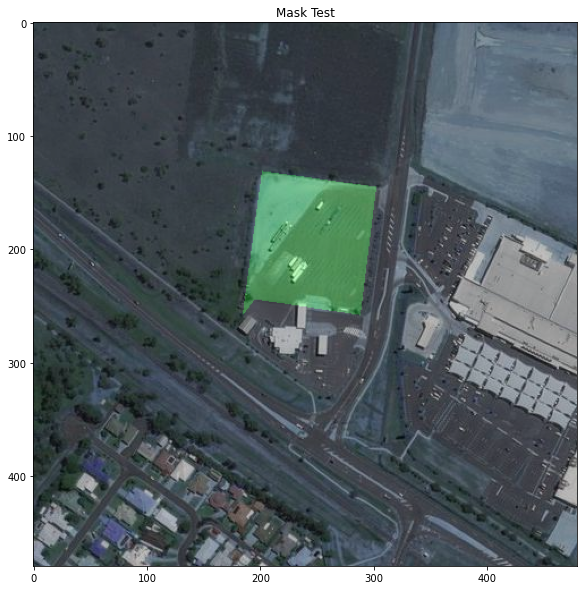

In [26]:
# Checking labels
filenames = os.listdir(DATA_PATH)
filenames = [x[:-5] for x in filenames if x.endswith(".jpeg")]
rnr = random.randrange(0, len(filenames))

idx = filenames[rnr]
#idx = "<<ID>>" # Or specify fielname without extension here
print(idx)

path_jpeg = f"{DATA_PATH}/{idx}.jpeg"
path_png  = f"{DATA_PATH}/{idx}-MASK.png"

image1 = cv2.imread(path_jpeg, 1)
image2 = cv2.imread(path_png, 1)

image1 = np.array(image1)
image2 = np.array(image2)


plt.figure(figsize=(10, 10))

plt.title('Mask Test')
plt.imshow(image1)

plt.imshow(image2, alpha=0.25) # cmap="Greens",

plt.show()
